In [1]:
!git clone https://github.com/vin136/bayesian-methods.git

Cloning into 'bayesian-methods'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 32 (delta 4), reused 28 (delta 4), pack-reused 0
Unpacking objects: 100% (32/32), done.


In [4]:
!ls bayesian-methods

data  nbs  README.md


In [6]:
## load-packages
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
from scipy import special, stats
import numpy as np

import theano

import datetime
print(f"Last Run {datetime.datetime.now()}")


#setting style
az.style.use("arviz-grayscale")
plt.rcParams['figure.dpi'] = 300

def plot_label_resizer(axes, fontsize=14):
    """Resizes the axes labels of plots"""
    for ax in axes.ravel():
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                     ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(fontsize)
    return

Last Run 2022-01-30 21:51:23.014948


# Exploratory Analysis


- Prior predictive check: see if your priors don't make non-sensible values plausible but also leave room for surprises.
- Posterior predictive check: generate data after fit and check if it looks like the actual data.

In [7]:
Y = stats.bernoulli(0.7).rvs(100)
with pm.Model() as model:
    theta = pm.Beta("theta", 1, 1)
    y_obs = pm.Binomial("y_obs",n=1, p=theta, observed=Y)
    trace_b = pm.sample(1000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  """
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


In [9]:
pred_dist = pm.sample_posterior_predictive(trace_b, 1000, model=model)["y_obs"]

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


Text(0, 0.5, 'probability')

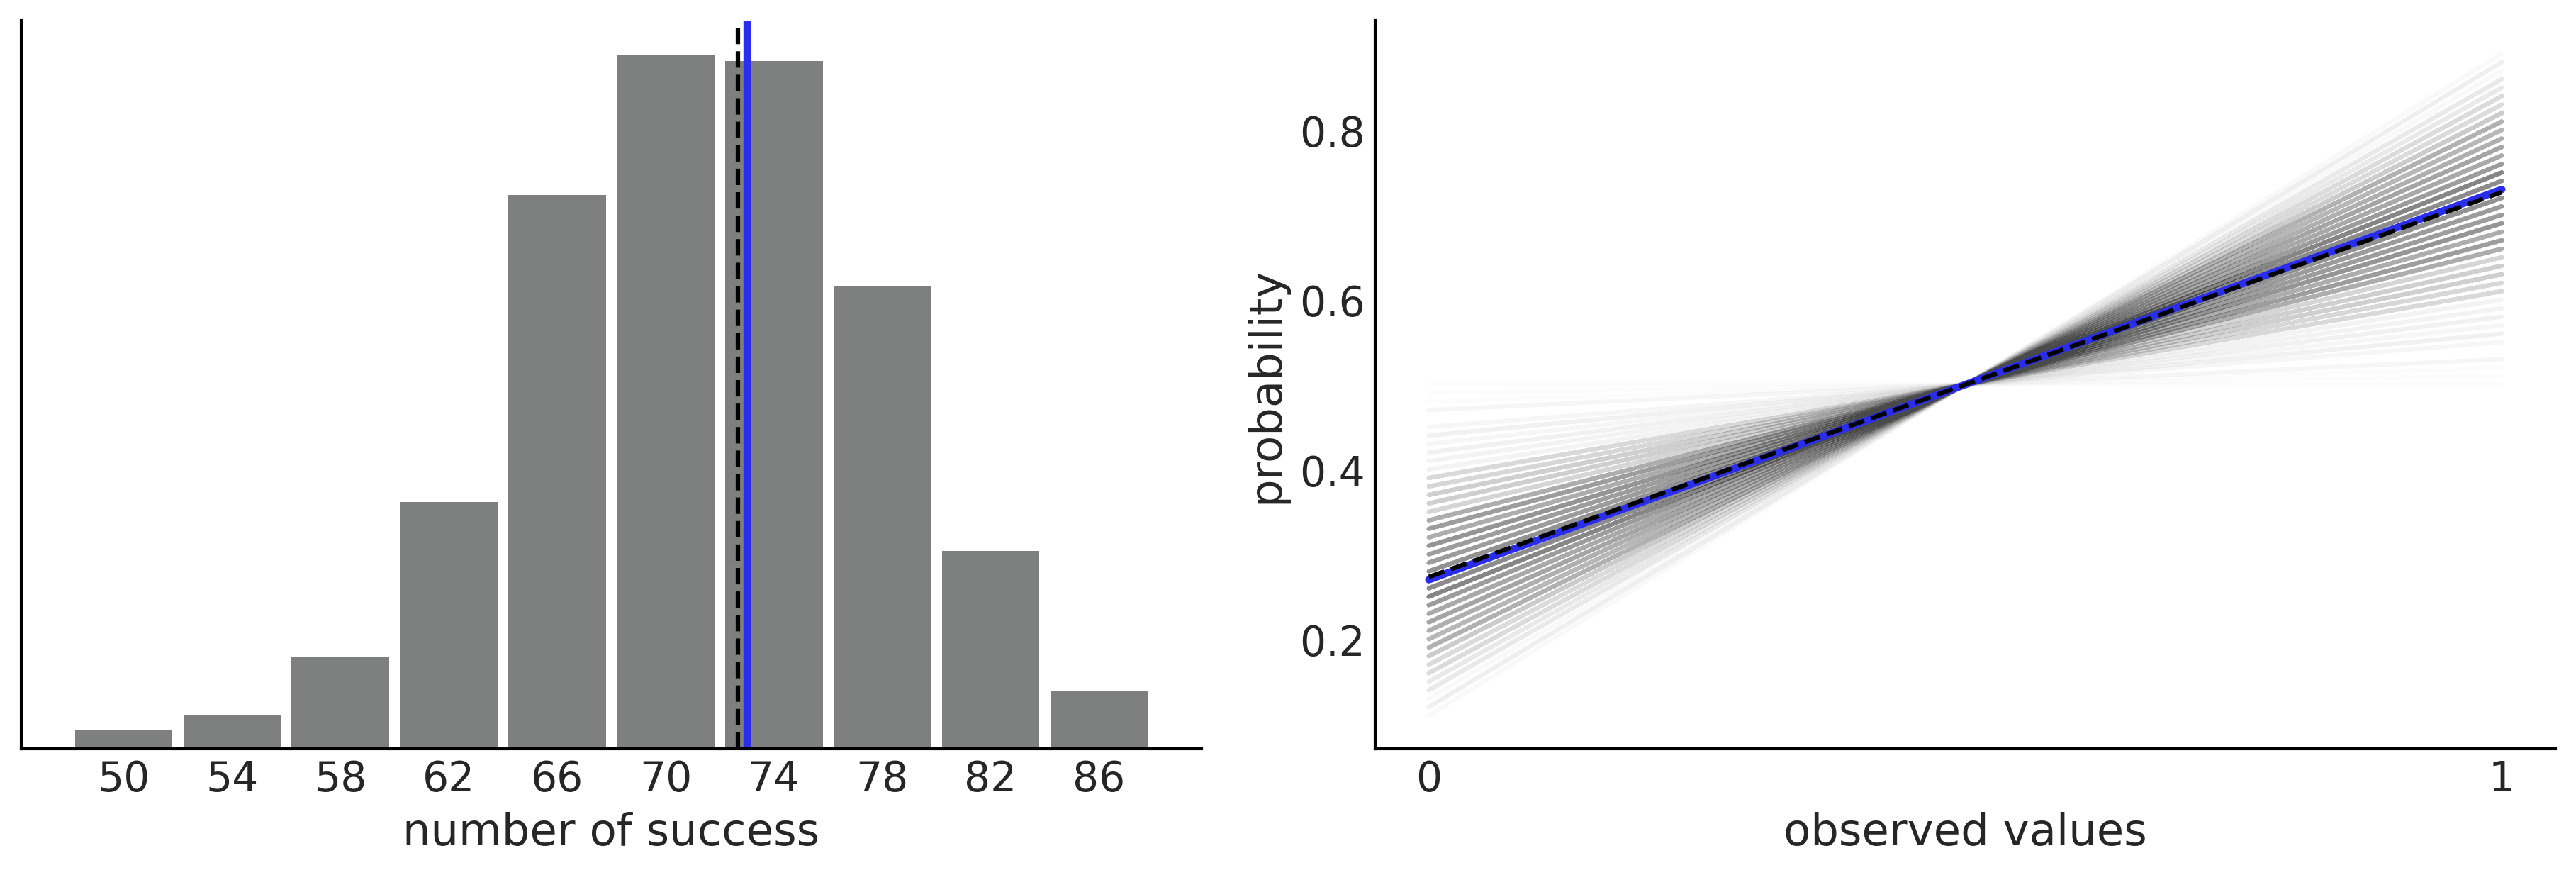

In [10]:
_, ax = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

az.plot_dist(pred_dist.sum(1),
             hist_kwargs={"color":"C2"}, ax=ax[0])
ax[0].axvline(Y.sum(), color="C4", lw=2.5);
ax[0].axvline(pred_dist.sum(1).mean(), color="k", ls="--")
ax[0].set_yticks([])
ax[0].set_xlabel("number of success")

pps_ = pred_dist.mean(1)
ax[1].plot((np.zeros_like(pps_), np.ones_like(pps_)), (1-pps_, pps_), 'C1', alpha=0.01)

ax[1].plot((0, 1), (1-Y.mean(), Y.mean()), 'C4', lw=2.5)
ax[1].plot((0, 1), (1-pps_.mean(), pps_.mean()), 'k--')
ax[1].set_xticks((0,1))
ax[1].set_xlabel("observed values")
ax[1].set_ylabel("probability")


In [14]:
sum(pred_dist[0])

73

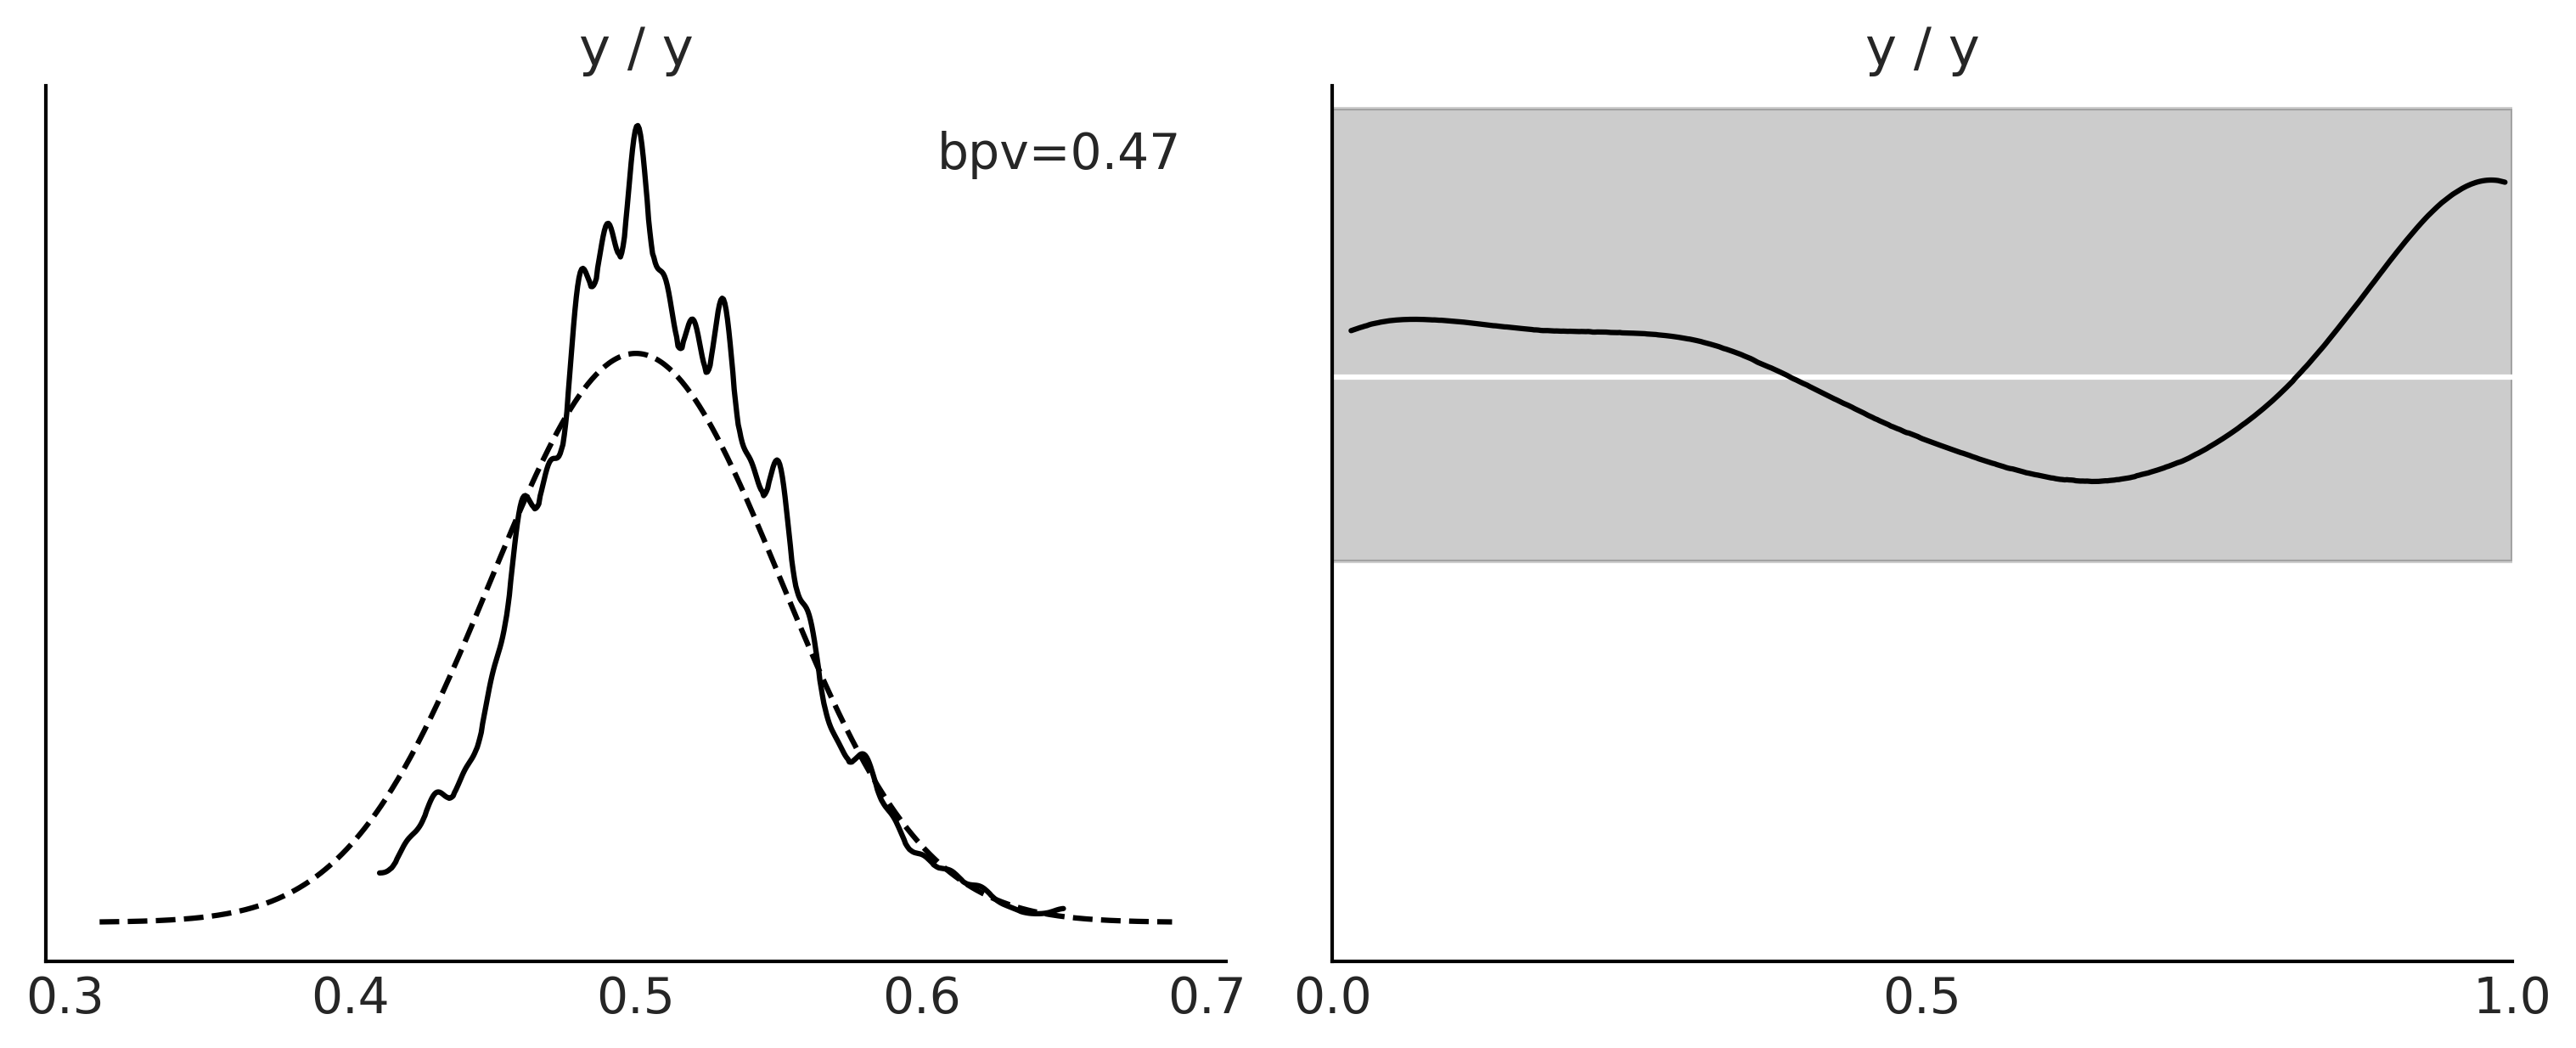

In [15]:
idata = az.from_dict(posterior_predictive={"y":pred_dist.reshape(2, 500, 100)}, observed_data={"y":Y})
_, ax = plt.subplots(1, 2, figsize=(10, 4))
az.plot_bpv(idata, kind="p_value", ax=ax[0])
ax[0].legend([f"bpv={(Y.mean() > pred_dist.mean(1)).mean():.2f}"], handlelength=0)
az.plot_bpv(idata, kind="u_value", ax=ax[1])
ax[1].set_yticks([])
ax[1].set_xticks([0., 0.5, 1.])

CHECK IF YOUR CHAINS ARE all good

- r_hat <= 1.01
- since samples are correlated bad-chains can have much smaller effective sample size than the actual samples. Ideally they should be close to actual ones,atleast not too small.
- Monte carlo standard error(mcse) - once above two are good,(ESS is highenough, and r_hat low enough,then mcse should be small enough.
- call az.summary to see all these.
- Next use trace-plots to see if all chains look same and there is no autocorrelation.



In [17]:
#example
np.random.seed(5201)
good_chains = stats.beta.rvs(2, 5,size=(2, 2000))
bad_chains0 = np.random.normal(np.sort(good_chains, axis=None), 0.05,
                               size=4000).reshape(2, -1)

bad_chains1 = good_chains.copy()
for i in np.random.randint(1900, size=4):
    bad_chains1[i%2:,i:i+100] = np.random.beta(i, 950, size=100)

chains = {"good_chains":good_chains,
          "bad_chains0":bad_chains0,
          "bad_chains1":bad_chains1}
az.summary(chains, kind="diagnostics")


,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
good_chains,0.002,0.002,4389.0,3966.0,1.00
bad_chains0,0.108,0.088,2.0,11.0,2.41
bad_chains1,0.018,0.013,111.0,105.0,1.03


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff1407c2610>,
      dtype=object)

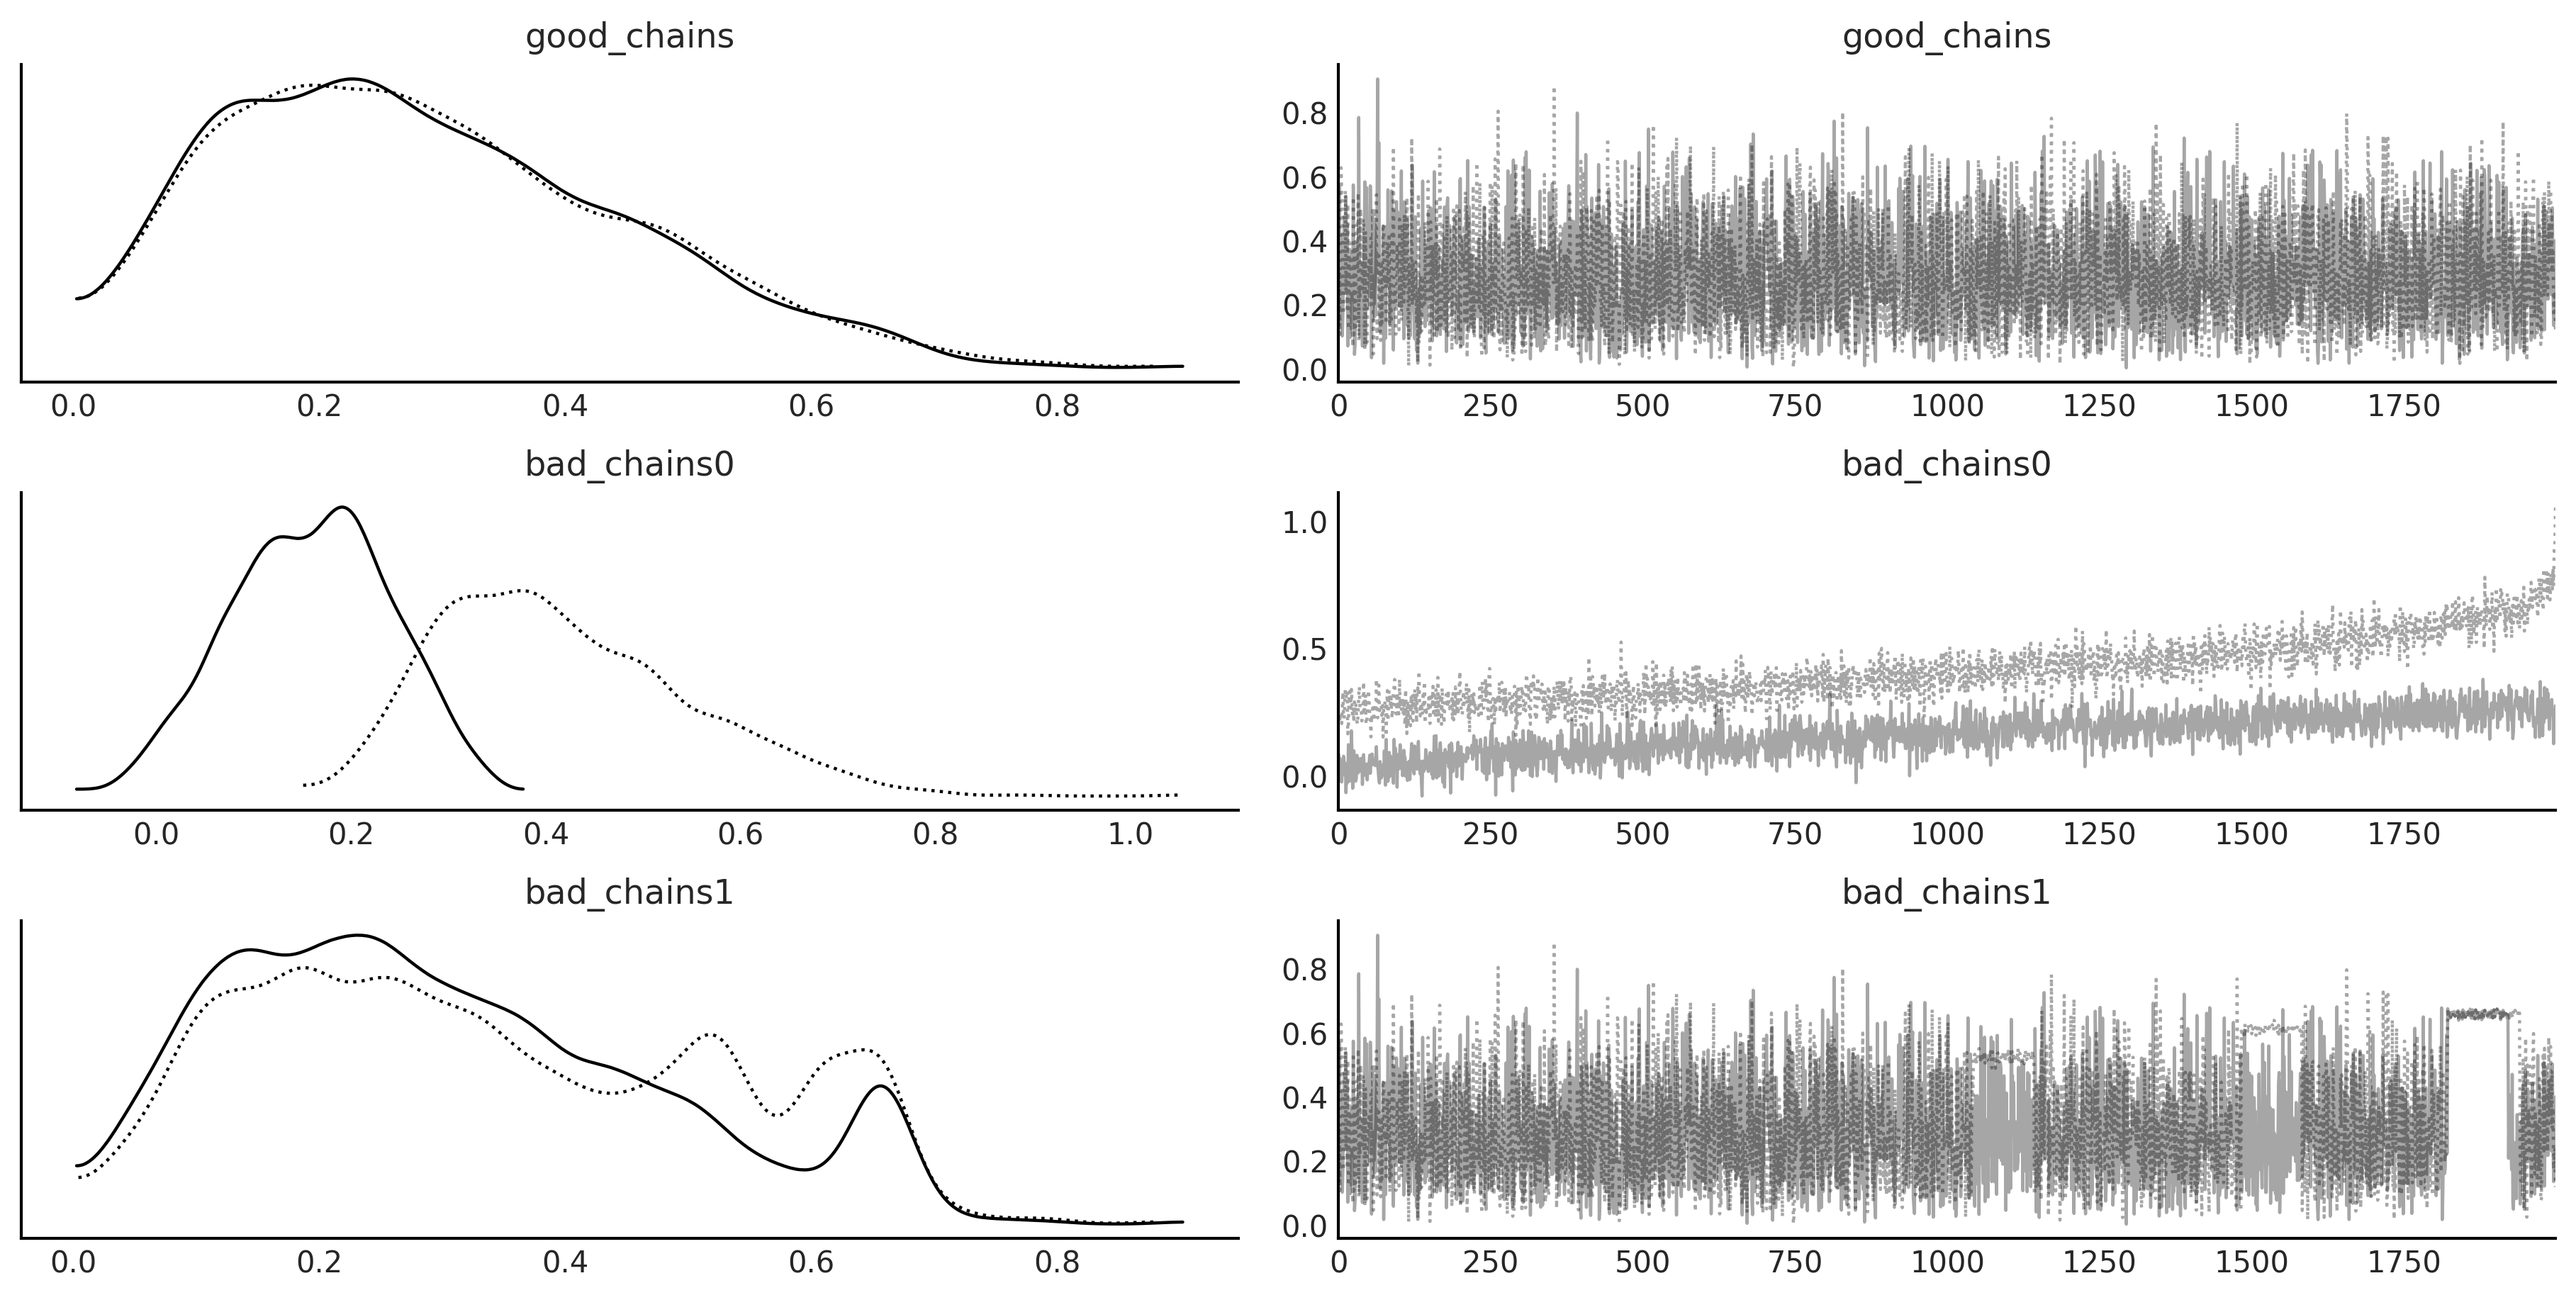

In [18]:
az.plot_trace(chains)

## Model Comparision

# Studying Penguins

In [19]:
import os
os.listdir('bayesian-methods/data')
data_dir = 'bayesian-methods/data/'

FileNotFoundError: ignored

In [3]:
penguins = pd.read_csv(data_dir+"penguins.csv")

NameError: ignored

In [ ]:
penguins.describe()

In [ ]:
penguins.head(4)

In [ ]:
penguins['species'].unique()

In [ ]:
penguins.groupby('species').mean()

Theres is certainly some variation between groups. Some are heavier and bigger than others.

In [ ]:
#clean the data
is_missing = penguins.isnull()[["bill_length_mm", "flipper_length_mm", "sex", "body_mass_g"]
].any(axis=1)
penguins = penguins.loc[~is_missing]

In [ ]:
penguins.shape

In [ ]:
penguins.columns

In [ ]:
penguins[['species','body_mass_g']].groupby('species').agg(['mean','std','count'])

## From point estimates to full distributions

likelihood,prior -> reasonable gaussian


In [ ]:
mask = penguins['species'] == 'Adelie'
adelie_mass_data = penguins[mask]['body_mass_g'].values
adelie_mass_data

In [ ]:
with pm.Model() as adelie_mass_model:
  mu = pm.Normal("mu",4000,3000)
  sigma = pm.Exponential('sigma',lam=0.003)
  mass = pm.Normal('mass',mu=mu,sigma=sigma,observed=adelie_mass_data)

  prior = pm.sample_prior_predictive(samples=5000)
  trace = pm.sample(chains=4)
  inf_data_adelie_penguin_mass = az.from_pymc3(prior=prior, trace=trace)

In [ ]:
axes = az.plot_posterior(inf_data_adelie_penguin_mass.prior, var_names=["sigma", "mu"], textsize=20)

Checking if we can trust the sampler

In [ ]:
axes = az.plot_trace(inf_data_adelie_penguin_mass, divergences="bottom", kind="rank_bars")


plot_label_resizer(axes, fontsize=16)

In [ ]:
az.summary(inf_data_adelie_penguin_mass)

In [ ]:
axes = az.plot_posterior(inf_data_adelie_penguin_mass, hdi_prob=.94, textsize=26);

Let's do the same for all species - Fit a distribution for masses of each penguin group

In [ ]:
species = pd.Categorical(penguins['species'])

with pm.Model() as model_penguins_all_sepcies:
  #shape is like simultaneously having 3 distributions
  sigma = pm.Exponential('sigma',lam=0.003,shape=3)
  mu = pm.Normal('mu',4000,3000,shape=3)
  mass = pm.Normal('mass',mu=mu[species.codes],sigma=sigma[species.codes],observed=penguins['body_mass_g'])
  trace = pm.sample()
  inf_data_model_all_species = az.from_pymc3(trace=trace,
                                             coords={"mu_dim_0":species.categories,
                                                     "sigma_dim_0":species.categories})

In [ ]:
axes = az.plot_trace(inf_data_model_all_species, compact=False, divergences="bottom", kind="rank_bars");

plot_label_resizer(axes, fontsize=16)

In [ ]:
axes = az.plot_forest(inf_data_model_all_species, var_names=["mu"], figsize=(8, 2.5))
axes[0].set_title("μ Mass Estimate: 94.0% HDI")

In [ ]:
axes = az.plot_forest(inf_data_model_all_species, var_names=["sigma"], figsize=(8, 2.5))
axes[0].set_title("sigma Mass Estimate: 94.0% HDI")

## Linear Regression